In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import os
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import save_image
from tqdm import tqdm 
from sklearn.decomposition import PCA
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set random seeds for reproducibility
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
random.seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Rest of your code goes here
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 8)
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(8, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()  # Use Sigmoid for final layer to get output in range [0, 1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    def get_latent_vector(self, x):
        return self.encoder(x)
    
# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.view(-1))])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=128,  num_workers=8, shuffle=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
test_loader = DataLoader(test_dataset, batch_size=128,  num_workers=8, shuffle=False)




In [43]:
from sklearn.manifold import TSNE
import torch
import numpy as np
import random
import matplotlib.pyplot as plt

def save_latent_space(model, device, test_loader, path, num_batches=None, save=True):
    # Extract latent representations
    model.eval()
    label_path = path + "labels.npy"
    latent_path = path + "latent_space.npy"
    
    with torch.no_grad():
        latent_space = []
        labels = []
        batch_count = 0  # Initialize batch counter
        
        for images, digit_labels in test_loader:
            if num_batches is not None and batch_count >= num_batches:
                break  # Stop if the specified number of batches is processed
                
            images = images.to(device)
            latents = model.get_latent_vector(images).cpu().numpy()
            latent_space.append(latents)
            labels.append(digit_labels.cpu().numpy())
            
            batch_count += 1  # Increment batch counter

        latent_space = np.concatenate(latent_space)
        labels = np.concatenate(labels)
        
        # Apply t-SNE to reduce dimensions to 2
        tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
        pca = PCA(n_components=2)
        latent_2d = tsne.fit_transform(latent_space)
        # latent_2d = pca.fit_transform(latent_space)
        # Normalize latent_2D between 0 and 1 in each direction
        normalized_latent_2D = (latent_2d - np.min(latent_2d, axis=0)) / (np.max(latent_2d, axis=0) - np.min(latent_2d, axis=0))

        # Visualize the latent space
        plt.figure(figsize=(10, 8))
        scatter = plt.scatter(normalized_latent_2D[:, 0], normalized_latent_2D[:, 1], c=labels, cmap='tab10', alpha=0.6, edgecolor='k')
        plt.colorbar(scatter)
        plt.xlabel('t-SNE Dimension 1')
        plt.ylabel('t-SNE Dimension 2')
        plt.title('2D t-SNE Projection of Latent Space')
        plt.show()
        
        if(save):
            np.save(latent_path, latent_2d)
            np.save(label_path, labels)


In [11]:

# Model, Loss Function, Optimizer
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
num_epochs = 20
for epoch in range(num_epochs):
    for idx, data in enumerate(train_loader):
        img, _ = data
        img = img.to(device)
        
        # Forward pass
        output = model(img)
        loss = criterion(output, img)
                
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    
# os.makedirs(f'images/latent_space8D/{epoch}/', exist_ok=True)
# save_latent_space(model, device, train_loader, path=f'images/latent_space8D/{epoch}/', num_batches=3)


print("Training finished!")

Epoch [1/20], Loss: 0.0512
Epoch [2/20], Loss: 0.0436
Epoch [3/20], Loss: 0.0385
Epoch [4/20], Loss: 0.0331
Epoch [5/20], Loss: 0.0313
Epoch [6/20], Loss: 0.0290
Epoch [7/20], Loss: 0.0264
Epoch [8/20], Loss: 0.0266
Epoch [9/20], Loss: 0.0249
Epoch [10/20], Loss: 0.0244
Epoch [11/20], Loss: 0.0242
Epoch [12/20], Loss: 0.0251
Epoch [13/20], Loss: 0.0215
Epoch [14/20], Loss: 0.0217
Epoch [15/20], Loss: 0.0202
Epoch [16/20], Loss: 0.0239
Epoch [17/20], Loss: 0.0229
Epoch [18/20], Loss: 0.0218
Epoch [19/20], Loss: 0.0194
Epoch [20/20], Loss: 0.0208
Training finished!


/home/modrzyk/miniconda3/envs/Manim/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


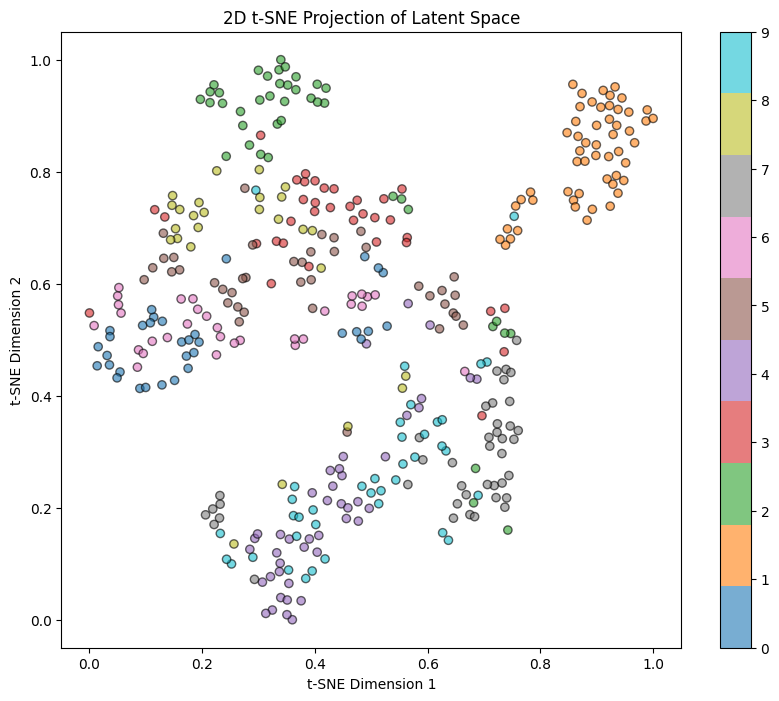

In [13]:
from sklearn.manifold import TSNE
import torch
import numpy as np
import random
import matplotlib.pyplot as plt

# Extract latent representations
model.eval()
num_batches = 3

with torch.no_grad():
    latent_space = []
    labels = []
    batch_count = 0  # Initialize batch counter
    
    for images, digit_labels in test_loader:
        if num_batches is not None and batch_count >= num_batches:
            break  # Stop if the specified number of batches is processed
            
        images = images.to(device)
        latents = model.get_latent_vector(images).cpu().numpy()
        latent_space.append(latents)
        labels.append(digit_labels.cpu().numpy())
        
        batch_count += 1  # Increment batch counter

    latent_space = np.concatenate(latent_space)
    labels = np.concatenate(labels)
    # latent_2d = latent_space
    # Apply t-SNE to reduce dimensions to 2
    tsne = TSNE(n_components=2, perplexity=20, n_iter=1000, learning_rate=50, random_state=42)
    latent_2d = tsne.fit_transform(latent_space)
    normalized_latent_2D = (latent_2d - np.min(latent_2d, axis=0)) / (np.max(latent_2d, axis=0) - np.min(latent_2d, axis=0))

    # Visualize the latent space
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(normalized_latent_2D[:, 0], normalized_latent_2D[:, 1], c=labels, cmap='tab10', alpha=0.6, edgecolor='k')
    plt.colorbar(scatter)
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.title('2D t-SNE Projection of Latent Space')
    plt.show()

In [9]:
path = f'images/latent_space8D/'

label_path = path + "labels.npy"
latent_path = path + "latent_space.npy"
    
np.save(latent_path, normalized_latent_2D)
np.save(label_path, labels)


0.16106151044368744 0.07424513250589371 0.13268069922924042


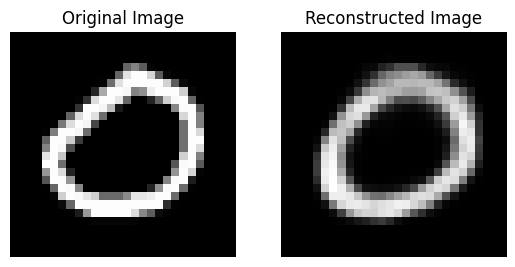

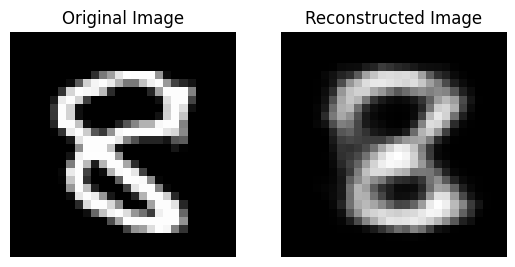

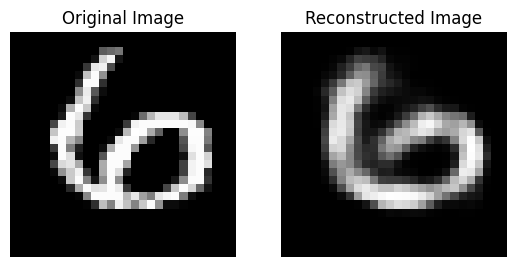

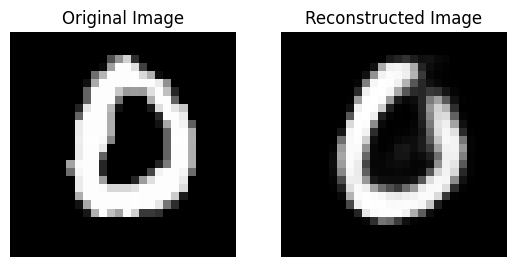

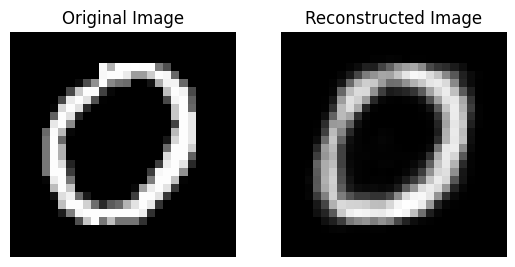

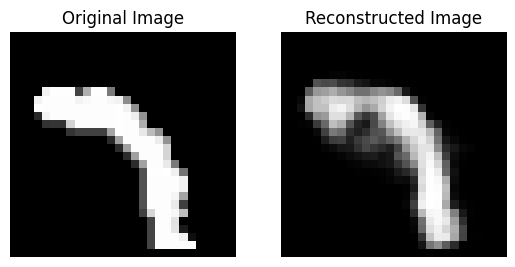

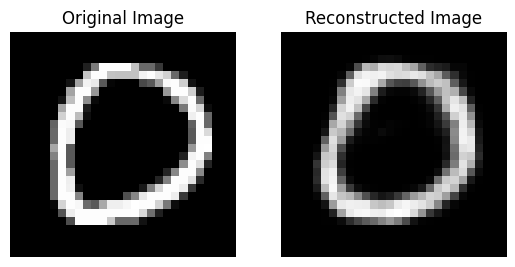

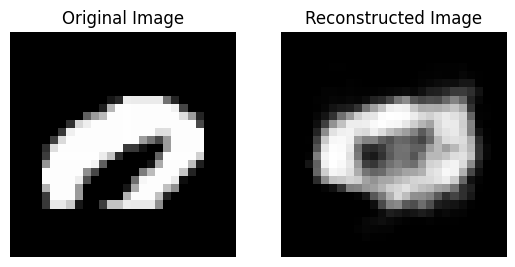

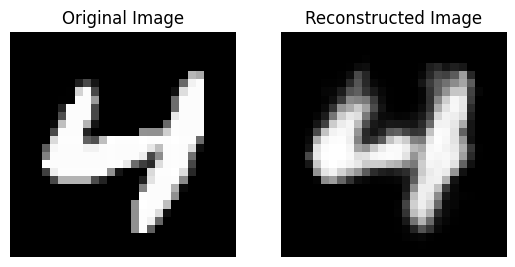

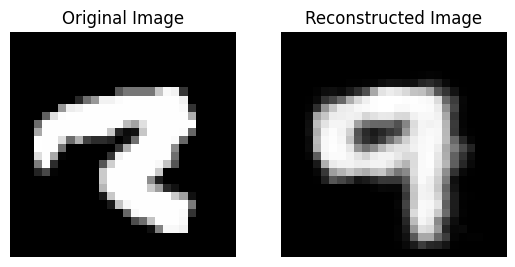

In [59]:
model.eval()
batch_index = 13

with torch.no_grad():
    latent_space = []
    labels = []
    batch_count = 0  # Initialize batch counter
    
    for images, digit_labels in test_loader:
        if batch_count == batch_index:
            images = images.to(device)
            recons = model(images)
            
            mses = []
            
            for img in images:
                mse = criterion(img, recons)
                mses.append(mse.item())
            
            highest_indices = np.argsort(mses)[-10:]
            
            print(max(mses), min(mses), mses[highest_indices[0]])
            for i in highest_indices:
                img = images[i].cpu().numpy()
                recons_img = recons[i].cpu().numpy()
                plt.figure()
                plt.subplot(1, 2, 1)
                plt.imshow(img.reshape(28, 28), cmap='gray')
                plt.title('Original Image')
                plt.axis('off')
                plt.subplot(1, 2, 2)
                plt.imshow(recons_img.reshape(28, 28), cmap='gray')
                plt.title('Reconstructed Image')
                plt.axis('off')
                plt.show()
            
            plt.imsave("./images/missreconstructions/image_2.png",images[highest_indices[9]].cpu().numpy().reshape(28, 28), cmap='gray')
            plt.imsave("./images/missreconstructions/recon_2.png",recons[highest_indices[9]].cpu().numpy().reshape(28, 28), cmap='gray')
        batch_count += 1
                

In [8]:
latent_space_1 = np.load('images/latent_space3D/0/latent_space.npy')
labels_1 = np.load('images/latent_space3D/0/labels.npy')



In [10]:
latent_space_1 = np.load('images/latent_space3D/0/latent_space.npy')
labels_1 = np.load('images/latent_space3D/0/labels.npy')

min = [0,0,0]
max = [0,0,0]


for i in range(0, 20):
    latent_space = np.load(f'images/latent_space3D/{i}/latent_space.npy')
    if(np.min(latent_space, axis=0)[0] < min[0]):
        min[0] = np.min(latent_space, axis=0)[0]
    if(np.min(latent_space, axis=0)[1] < min[1]):
        min[1] = np.min(latent_space, axis=0)[1]
    if(np.min(latent_space, axis=0)[2] < min[2]):
        min[2] = np.min(latent_space, axis=0)[2]
    if(np.max(latent_space, axis=0)[0] > max[0]):
        max[0] = np.max(latent_space, axis=0)[0]
    if(np.max(latent_space, axis=0)[1] > max[1]):  
        max[1] = np.max(latent_space, axis=0)[1]
    if(np.max(latent_space, axis=0)[2] > max[2]):
        max[2] = np.max(latent_space, axis=0)[2]
    
    
print(min, max)

[-33.454647, 0, -22.474812] [3.6926215, 52.239986, 5.131909]


In [122]:
from torch.utils.data import DataLoader, Dataset
# Custom Dataset to filter for specific class
class FilteredMNIST(Dataset):
    def __init__(self, dataset, target_class):
        self.dataset = dataset
        self.target_class = target_class
        self.filtered_indices = [i for i, (img, label) in enumerate(dataset) if label == target_class]
        
    def __len__(self):
        return len(self.filtered_indices)
    
    def __getitem__(self, idx):
        img, label = self.dataset[self.filtered_indices[idx]]
        return img, label

# Create a DataLoader for class "1"
class_of_interest = 4
filtered_dataset = FilteredMNIST(test_dataset, class_of_interest)
filtered_loader = DataLoader(filtered_dataset, batch_size=64, shuffle=False)

# Initialize and load the autoencoder
autoencoder = Autoencoder().to(device)
# Here you should load your trained model if you have one
# For example: autoencoder.load_state_dict(torch.load('autoencoder.pth'))

# Encode the filtered images and get latent vectors
latent_vectors = []

# Put the autoencoder in evaluation mode
autoencoder.eval()

with torch.no_grad():  # No need to calculate gradients for encoding
    for data, _ in filtered_loader:
        data = data.to(device)
        latent_vector = autoencoder.get_latent_vector(data)
        latent_vectors.append(latent_vector.cpu().numpy())
        
coordx = []
coordy = []

for i in range(5):
    data = filtered_dataset[i][0].to(device)
    plt.imsave(f'images/mnist/instances1D/4/image_{i}.png', data.cpu().view(28, 28).numpy(), cmap='gray')
    coordx.append(autoencoder.get_latent_vector(data).cpu().detach().numpy()[0])
    coordy.append(autoencoder.get_latent_vector(data).cpu().detach().numpy()[1])
print(coordx)
print(coordy)

[0.19417866, 0.2028715, 0.18586662, 0.19200861, 0.18419224]
[-0.26655468, -0.2717467, -0.2731771, -0.26910043, -0.27389488]


Latent Vector: [-0.13872708  0.19705535 -0.12725732]
Latent Vector: [-0.13909423  0.19762832 -0.12714055]
Latent Vector: [-0.13961726  0.19671509 -0.12767175]
Latent Vector: [-0.14970262  0.1981884  -0.12709059]
Latent Vector: [-0.15283482  0.19146085 -0.13345799]
Latent Vector: [-0.1475017   0.19250475 -0.1320731 ]
Latent Vector: [-0.14117128  0.19860838 -0.12802106]
Latent Vector: [-0.143081    0.19315517 -0.1292764 ]
Latent Vector: [-0.14784163  0.19782856 -0.12800038]
Latent Vector: [-0.1417465   0.1938808  -0.12963866]


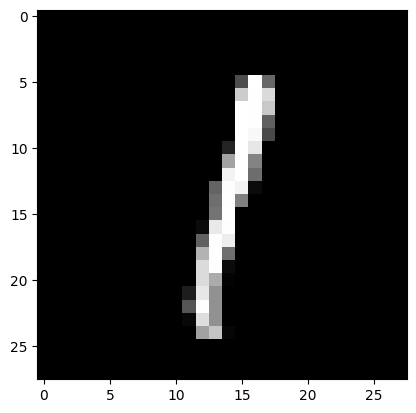

In [ ]:
# Function to add noise to images
def add_noise(images, noise_factor=0.3):
    noisy_images = images + noise_factor * torch.randn(*images.shape, device=images.device)
    noisy_images = torch.clip(noisy_images, 0., 1.)
    return noisy_images

# Function to display images
def show_images(original, noisy, reconstructed, n=10):
    plt.figure(figsize=(18, 6))
    for i in range(n):
        # Original
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(original[i].reshape(28,28), cmap='gray')
        ax.axis('off')
        if i == 0:
            ax.set_title('Original')
        
        # Noisy
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(noisy[i].reshape(28,28), cmap='gray')
        ax.axis('off')
        if i == 0:
            ax.set_title('Noisy')
        
        # Reconstructed
        ax = plt.subplot(3, n, i + 1 + 2 * n)
        plt.imshow(reconstructed[i].reshape(28,28), cmap='gray')
        ax.axis('off')
        if i == 0:
            ax.set_title('Reconstructed')
    plt.show()

# Get a batch of test images
test_images, _ = next(iter(test_loader))
test_images = test_images.to(device)

# Reconstruct images
with torch.no_grad():
    reconstructed_images = model(test_images)

# Add noise to test images
noisy_images = add_noise(test_images)

# Reconstruct noisy images
with torch.no_grad():
    reconstructed_noisy_images = model(noisy_images)

# Convert images to numpy for visualization
test_images = test_images.cpu().numpy()
noisy_images = noisy_images.cpu().numpy()
reconstructed_images = reconstructed_images.cpu().numpy()
reconstructed_noisy_images = reconstructed_noisy_images.cpu().numpy()

# Display images
show_images(test_images, noisy_images, reconstructed_images, n=10)
show_images(noisy_images, noisy_images, reconstructed_noisy_images, n=10)

In [44]:
from torchvision.utils import save_image
import matplotlib.pyplot as plt

for i in range(4):  
    plt.imsave(f'./images/mnist/original_{i}.png', test_images[i].reshape(28,28), cmap='gray')
    plt.imsave(f'./images/mnist/noisy_{i}.png', noisy_images[i].reshape(28,28), cmap='gray')
    plt.imsave(f'./images/mnist/reconstructed_{i}.png', reconstructed_images[i].reshape(28,28), cmap='gray')
    plt.imsave(f'./images/mnist/reconstructed_noisy_{i}.png', reconstructed_noisy_images[i].reshape(28,28), cmap='gray')
    

tensor([-7.4361, -2.6537, -7.0978], device='cuda:0', grad_fn=<AddBackward0>)


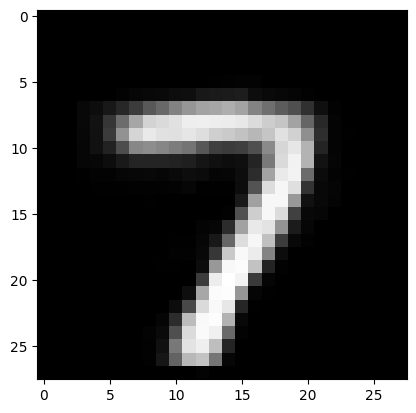

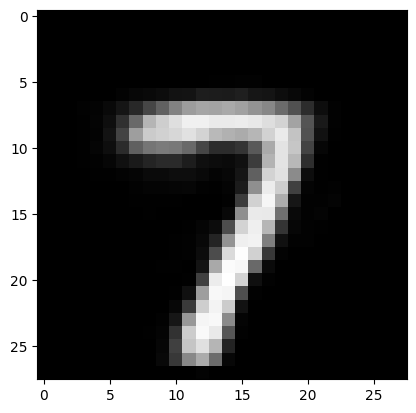

In [57]:
test_images, _ = next(iter(test_loader))
test_images = test_images.to(device)
encoded = model.encoder(test_images[0])
print(encoded)

clean_decoded = model.decoder(encoded)
near_decoded = model.decoder(encoded + 1)
plt.imshow(clean_decoded.cpu().detach().numpy().reshape(28,28), cmap='gray')
plt.show()
plt.imshow(near_decoded.cpu().detach().numpy().reshape(28,28), cmap='gray')
plt.show()